<a href="https://colab.research.google.com/github/zrruziev/Deep_Learning_Practice/blob/main/TDC/C4_W3_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Utilities


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

##Generate the Synthetic Data


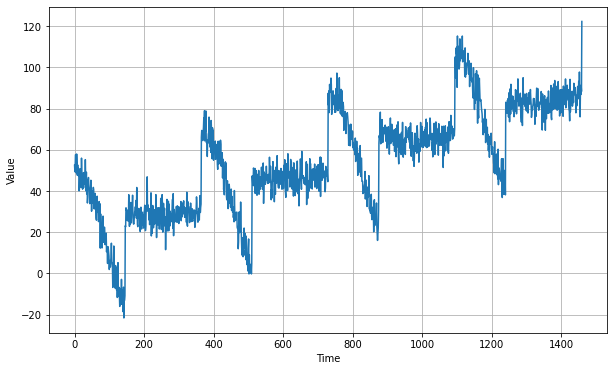

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

##Split the Dataset


In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

##Prepare Features and Labels


In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.map(lambda w: (w[:-1], w[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

##Build the Model

In [9]:
model_tune = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x*100.0)
            ])

model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 64)           8704      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

##Tune the Learning Rate

In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(momentum=.9)

model_tune.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 13s 24ms/step - loss: 101.6629 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 100.6102 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 99.3333 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 97.8905 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 96.2711 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 94.4486 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 92.3944 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 22ms/step - loss: 90.0862 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 22ms/step - loss: 87.4909 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 22ms/step - loss: 84.5646 - lr: 2.8184e-08
Epoch 

##Find out best Learning Rate

(1e-08, 0.001, 0.0, 30.0)

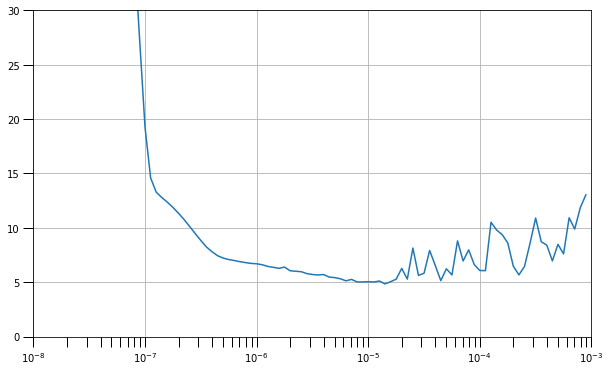

In [18]:
lrs = 1e-8*(10**(np.arange(100)/20))

plt.figure(figsize=(10,6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 30])


##Train the Model with choosen Learning Rate

In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100.0)
        ])

learning_rate = 1e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='tb_logs')

history = model.fit(dataset, epochs=100, callbacks=[tensorboard])

Epoch 1/100
31/31 [==============================] - 8s 23ms/step - loss: 23.0810 - mae: 23.5772
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 12.7543 - mae: 13.2485
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 10.0952 - mae: 10.5841
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 8.1618 - mae: 8.6457
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 7.3196 - mae: 7.7987
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 7.0704 - mae: 7.5501
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 6.9431 - mae: 7.4247
Epoch 8/100
31/31 [==============================] - 1s 23ms/step - loss: 6.8224 - mae: 7.3032
Epoch 9/100
31/31 [==============================] - 1s 23ms/step - loss: 6.7334 - mae: 7.2144
Epoch 10/100
31/31 [==============================] - 1s 23ms/step - loss: 6.6097 - mae: 7.0896
Epoch 11/100
31/31 [=======================

##Model Prediction

In [22]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

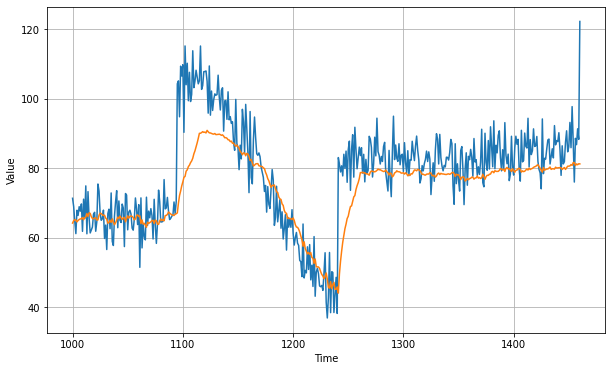

In [23]:
forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [24]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

95.21507
7.0149293


#(OPTIONAL)
##Use Validation set in Training

In [25]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)



##Train with validation set


In [27]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100.0)
        ])

learning_rate = 1e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(dataset, epochs=100, validation_data=val_set)

Epoch 1/100
31/31 [==============================] - 10s 89ms/step - loss: 22.2188 - mae: 22.7129 - val_loss: 33.6081 - val_mae: 34.1075
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 17.6751 - mae: 18.1702 - val_loss: 32.5601 - val_mae: 33.0596
Epoch 3/100
31/31 [==============================] - 1s 30ms/step - loss: 15.2616 - mae: 15.7527 - val_loss: 27.5703 - val_mae: 28.0685
Epoch 4/100
31/31 [==============================] - 1s 31ms/step - loss: 12.8020 - mae: 13.2916 - val_loss: 24.0908 - val_mae: 24.5894
Epoch 5/100
31/31 [==============================] - 1s 30ms/step - loss: 10.6478 - mae: 11.1386 - val_loss: 21.2905 - val_mae: 21.7889
Epoch 6/100
31/31 [==============================] - 1s 31ms/step - loss: 9.1601 - mae: 9.6453 - val_loss: 17.4096 - val_mae: 17.9057
Epoch 7/100
31/31 [==============================] - 1s 30ms/step - loss: 8.3247 - mae: 8.8076 - val_loss: 16.4948 - val_mae: 16.9909
Epoch 8/100
31/31 [==============================] 